# Obtaining structured web content and programmatic access

In this notebook we will learn how to make use of readily structured data through dedicated application programming interfaces (APIs), how to authenticate and how to properly design requests (also called "payload") in order to retrieve large datasets.

**Advantages** of APIs are that
- access is legal and in most cases clearly and transparently regulated (e.g. 10,000 calls per day)
- structuring through `requests` and `BeautifulSoup` not required
- Python packages that simplify server-client interaction are available

**Disadvantages** of APIs are that
- we have to learn how APIs work and how we should interact with them (each API has some peculiarities and documentation is usually good, but sometimes not so...)
- authentification may be required and access may not be free of charge 

We will
- obtain data of a public statistical office such as the IMF or World Bank through the `pandas-datareader`
- directly obtain a (ranking) table from a website such the [World Cube Association](https://www.worldcubeassociation.org/results/rankings/333/single)
- learn how to use the Destatis/GENESIS Online service and API
- learn how to use the Twitter API (in particular [Tweepy](https://www.tweepy.org/), a Python library for the Twitter API) and retrieve Tweets with GeoTags (i.e. coordinates) subject to specified geography and search terms
- conduct some small analyses and visualise the results appropriately

In [1]:
import pandas as pd

In [2]:
!pip install pandas-datareader --upgrade

In [3]:
from pandas_datareader import wb # imports world bank access
search = wb.search('GDP.*current.*US') # search for keyword
search

,id,name,unit,source,sourceNote,sourceOrganization,topics
9027,NV.SRV.DISC.CD,"Discrepancy in GDP, value added (current US$)",,Africa Development Indicators,This is the discrepancy included in the value ...,"b'World Bank national accounts data, and OECD ...",
9155,NY.GDP.DISC.CD,Discrepancy in expenditure estimate of GDP (cu...,,Africa Development Indicators,This is the discrepancy included in the ‘total...,"b'World Bank national accounts data, and OECD ...",
9166,NY.GDP.MKTP.CD,GDP (current US$),,World Development Indicators,GDP at purchaser's prices is the sum of gross ...,"b'World Bank national accounts data, and OECD ...",Economy & Growth
9185,NY.GDP.PCAP.CD,GDP per capita (current US$),,World Development Indicators,GDP per capita is gross domestic product divid...,"b'World Bank national accounts data, and OECD ...",Economy & Growth
9292,NYGDPMKTPSACD,"GDP,current US$,millions,seas. adj.,",,Global Economic Monitor,,b'',


In [4]:
df = wb.download(indicator = 'NY.GDP.MKTP.CD', country = ['DE', 'FR', 'IT'],
                start = 2000, end = 2019)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 60 entries, ('Germany', '2019') to ('Italy', '2000')
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NY.GDP.MKTP.CD  60 non-null     float64
dtypes: float64(1)
memory usage: 1.5+ KB


In [5]:
df.groupby('country').describe()

NY.GDP.MKTP.CD                                            \
                 count          mean           std           min   
country                                                            
France            20.0  2.391444e+12  5.039285e+11  1.362249e+12   
Germany           20.0  3.213212e+12  6.554315e+11  1.943145e+12   
Italy             20.0  1.907346e+12  3.611625e+11  1.143830e+12   

                                                                 
                  25%           50%           75%           max  
country                                                          
France   2.176030e+12  2.618880e+12  2.733605e+12  2.918383e+12  
Germany  2.836649e+12  3.409510e+12  3.730707e+12  3.963768e+12  
Italy    1.827731e+12  1.982686e+12  2.145770e+12  2.398857e+12

In [6]:
df2 = df.reset_index()

In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         60 non-null     object 
 1   year            60 non-null     object 
 2   NY.GDP.MKTP.CD  60 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.5+ KB


In [8]:
df2.columns = ['country', 'year', 'gdp'] # rename columns
df2.year = df2.year.astype(int) # numeric annual indicator
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  60 non-null     object 
 1   year     60 non-null     int32  
 2   gdp      60 non-null     float64
dtypes: float64(1), int32(1), object(1)
memory usage: 1.3+ KB


In [9]:
import matplotlib.pyplot as plt
import datetime

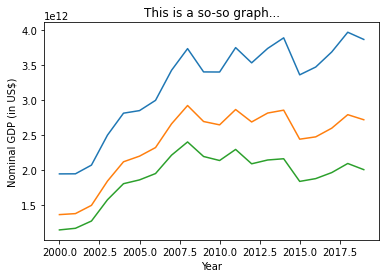

In [10]:
for country in df2['country'].unique():
    
    plt.plot(df2[df2['country'] == country]['year'], df2[df2['country'] == country]['gdp'], label = country)
    
    plt.xlabel('Year')
    plt.ylabel('Nominal GDP (in US$)')
    plt.title('This is a so-so graph...')

In [11]:
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [12]:
traces = []

for country in df2['country'].unique():
    
    trace = go.Scatter(name = country, x = df2[df2['country'] == country]['year'],
                      y = df2[df2['country'] == country]['gdp'])
    
    traces.append(trace)
    
fig = go.Figure(data = traces)

fig.layout.update(title=go.layout.Title(

    text = 'This is a much cooler graph!'

))

fig.layout.update(yaxis= go.layout.YAxis(title=go.layout.yaxis.Title(
                        text='Nominal GDP (in US$)')));

fig.layout.update(xaxis = go.layout.XAxis(title = go.layout.xaxis.Title(text = 'Year'), rangeslider = dict(visible = True)));

iplot(fig, filename = 'Nominal_GDP')

## Directly parsing `table` objects from HTML

In [ ]:
# Recall: %whos shows you the variables in name space

In [13]:
ranking = pd.read_html('https://www.worldcubeassociation.org/results/rankings/333/single', encoding='utf-8')

In [15]:
ranking[0]

,#,Name,Result,Citizen of,Competition,Unnamed: 5
0,1,Yusheng Du (杜宇生),3.47,China,Wuhu Open 2018,NaN
1,2,Feliks Zemdegs,4.16,Australia,Auckland Summer Open 2020,NaN
2,3,Patrick Ponce,4.24,United States,Northeast Championship 2019,NaN
3,4,Nicolás Sánchez,4.38,United States,GA Cubers Feet Fest 2019,NaN
4,5,Max Park,4.40,United States,SacCubing V 2018,NaN
...,...,...,...,...,...,...
95,90,Jonathan Esparaz,5.52,Canada,Oakville Limited Fall 2017,NaN
96,90,Lianhao Zhu (褚连皓),5.52,China,Shaoxing Morning 2021,NaN
97,98,Kim Roger Høyland Larsen,5.54,Norway,Voss Open 2019,NaN
98,99,Luke Tycksen,5.55,United States,Atomic Cubing Fall 2017,NaN


Which nationality appears most frequently in the World Cube Association's ranking?

Which nationality needed, on average, the **lowest** amount of time to solve a 3x3x3 cube? Sort the output in ascending order.

How many possible states/permutations, starting from the solved state, can a 3x3x3 Rubik's cube have? 

Hints:
1. The centre squares are fixed (a plane rotation around these squares doesn't change the cube's state)
2. There are eight corner pieces (with three colors on the side) and twelve edge pieces (with two colors on the side) which all revolve around the centre pieces
3. There are six different colors
4. We only look at "legal" states, i.e. those that can only be realised without assembling the cube (and therefore not violating Hint 1)

Which result entry in the World Ranking table is the most recent one? Which one is the oldest one? Be as precise as possible! (Hint: You may have to combine your knowledge from scraping HTML files.)

Compute the expected value of `Result` conditional on `Nationality = 'Germany'`. Are the German contestants statistically significantly faster/slower in solving the cube than other contestants, based on `Nationality`? Does statistical significance change if you use robust standard errors?

In [ ]:
!pip install statsmodels

In [ ]:
import statsmodels.api as sm

## Spatial libraries 
> (Note to myself: do GENESIS API first!)

The installation procedure of spatial libraries for Python (on Windows) can be quite tedious but [this answer](https://stackoverflow.com/questions/51095970/install-python-geopandas-failed/51560940#51560940) on Stackoverflow (make sure to upvote ;)) and [this detailed instruction](https://geoffboeing.com/2014/09/using-geopandas-windows/) make it straight forward. You can also find the required wheels for Python 3.8 and 64-bit for offline `pip install` in this notebook's [repository](https://github.com/gerwolf/webscraping-workshop/tree/main/DataFrames%20and%20APIs). After this, you can simply `pip install geopandas`.

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]

## Destatis/GENESIS Online
The GENESIS API is the web interface service by the Federal Statistical Office of Germany and is a good place to start learning how to interact programmatically with a server.

There is a [comprehensive description/introduction](https://www-genesis.destatis.de/genesis/misc/GENESIS-Webservices_Einfuehrung.pdf) on the service, unfortunately in German only. To display the PDF inside Jupyter Notebook in Chrome you may have to enable the [PDF Viewer extension](https://chrome.google.com/webstore/detail/pdf-viewer/oemmndcbldboiebfnladdacbdfmadadm?utm_source=chrome-ntp-icon).

In [16]:
from IPython.display import IFrame, display
filepath = "https://www-genesis.destatis.de/genesis/misc/GENESIS-Webservices_Einfuehrung.pdf"
IFrame(filepath, width=980, height=800)

Read about the `whoami` method (in Section 2.2). Do you have to authenticate? What does it return? How would you send a `request`?

In [18]:
import genesis_config
import requests

In [19]:
url = 'https://www-genesis.destatis.de/genesisWS/rest/2020/helloworld/whoami'
response = requests.get(url)
response.text

'{"User-Agent":"python-requests/2.25.1","User-IP":"95.91.213.125"}'

Read about the `logincheck` method (in Section 2.2). Do you have to authenticate? What does it return? Construct a request object using string formatting, send a `request` (in English language) and print the request's status. What type is the response's `text` attribute?

In [20]:
url = 'https://www-genesis.destatis.de/genesisWS/rest/2020/helloworld/logincheck?username={}&password={}&language={}'.format(genesis_config.Username, genesis_config.Password, 'en')
response = requests.get(url)

In [21]:
response.text

'{"Status":"You have been logged in and out successfully!","Username":"DE56JNILRL"}'

Now that we have a working connection to the GENESIS Online API we want to directly obtain an economic indicator, the private sector's savings rate on a quarterly basis, for instance. This `data` is usually stored in a `table` somewhere in the depths of a data warehouse and it is (unfortunately) necessary to familiarise yourself, at least partially, with the internal server's structure.
1. In the documentation file search for the `tablefile` method (under Section 2.5 Data). When should it be used? What does it return?
2. Which method should you use if you want to directly obtain a `chart`?
3. Which method should you use if you want to directly obtain a regional `map`? Which parameter controls the image's resolution?

In [22]:
field = '12411-0010'
stand = '31.12.2019'
language = 'en'
url = 'https://www-genesis.destatis.de/genesisWS/rest/2020/data/map2table?username={}&password={}&name={}&area=all&mapType=0&classes=5&classification=0&zoom=3&startyear=&endyear=&timeslices=&regionalvariable=&regionalkey=&classifyingvariable1=&classifyingkey1=&classifyingvariable2=&classifyingkey2=&classifyingvariable3=&classifyingkey3=&format=png&stand={}&language={}'.format(genesis_config.Username, genesis_config.Password, field, stand, language)
response = requests.get(url)

In [23]:
response.status_code

200

In [24]:
with open("map.png", 'wb') as f:
    f.write(response.content)

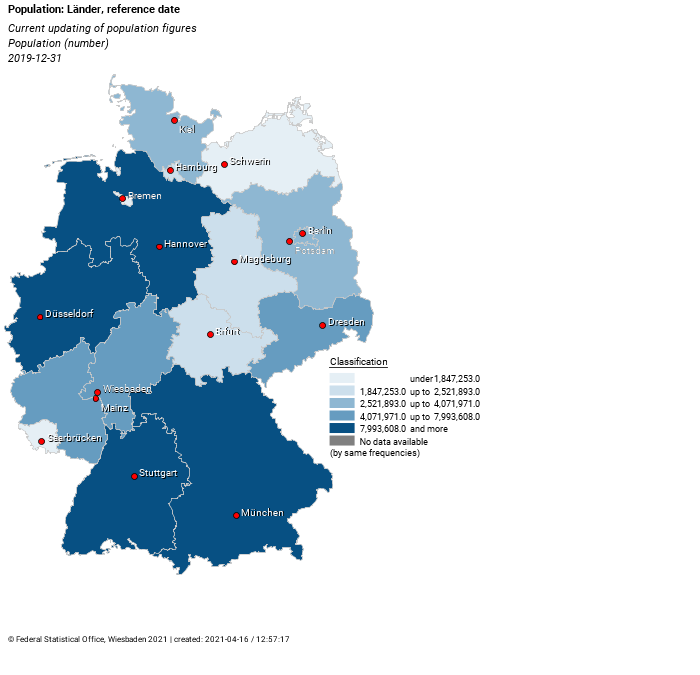

In [25]:
from IPython.display import Image
Image(filename='map.png')

4. Login to the [GENESIS Online user interface](https://www-genesis.destatis.de/genesis/online?Menu=Anmeldung#abreadcrumb). Familiarise yourself with the tables' structure and navigate to the National Accounts (at the central level) --> Private sector disposable income and savings at quarterly frequency. Which parameters in the request can you control?
5. Which method would you choose if you want to directly obtain a `table` in some machine readable format, e.g. a `.csv` or `.xlsx` that you can read into `pandas`? Which output `formats` can you choose from? How do you include additional conditions matching particular values?
6. Construct a `request` which contains the following specification:
    - only seasonally and calendar-adjusted values (X13)
    - all available years and quarters
    - output format should be a `.xlsx` file
7. Send the request, but directly through the `pandas.read_excel()` method.

In [26]:
! pip install openpyxl

In [33]:
code = '81000-0010'
key_1 = 'WERT04'
val_1 = 'X13JDKSB'
key_2 = ''
val_2 = ''
key_3 = ''
val_3 = ''
start_year = '1991'
end_year = '2020'

url = ('https://www-genesis.destatis.de/genesisWS/rest/2020/data/tablefile?username={}&password={}&name={}&area=DINSG*&compress=false&transpose=false&startyear={}&endyear={}&timeslices=&regionalvariable=&regionalkey=&classifyingvariable1={}&classifyingkey1={}&classifyingvariable2={}&classifyingkey2={}&classifyingvariable3={}&classifyingkey3={}&format=xlsx&job=false&stand=&language=de').format(genesis_config.Username, genesis_config.Password, code, start_year, end_year, key_1, val_1, key_2, val_2, key_3, val_3)
df = pd.read_excel(url)

C:\Users\wolfg\Anaconda3\envs\webscraping\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [35]:
import numpy as np

In [36]:
df = df.iloc[[2,3,37], :].T.iloc[2:,:]
df.columns = ['Year', 'Quarter', 'Rate']
df.reset_index(inplace = True, drop = True)
df['Year'] = df['Year'].fillna(method='ffill')
df['Quarter_str'] = df['Quarter'].copy()
df['Quarter'] = df['Quarter'].replace('1. Quartal', 'Q1')
df['Quarter'] = df['Quarter'].replace('2. Quartal', 'Q2')
df['Quarter'] = df['Quarter'].replace('3. Quartal', 'Q3')
df['Quarter'] = df['Quarter'].replace('4. Quartal', 'Q4')
df['Rate'] = df['Rate'].replace ('...', np.NaN)
qs = df['Year'] + '-' + df['Quarter']
df['Date'] = pd.PeriodIndex(qs.values, freq='Q').to_timestamp()
df.set_index(df['Date'], inplace = True, drop = True)
del df['Date']
df.dropna(inplace=True)
df['col_name'] = df['Quarter'] + ' ' + df['Year'].str[2:4]
col_names = list(df['col_name'].values)
df = df.T
df.columns = col_names
df = df.T

In [37]:
df

,Year,Quarter,Rate,Quarter_str,col_name
Q1 91,1991,Q1,12.6,1. Quartal,Q1 91
Q2 91,1991,Q2,13.6,2. Quartal,Q2 91
Q3 91,1991,Q3,12.7,3. Quartal,Q3 91
Q4 91,1991,Q4,12.7,4. Quartal,Q4 91
Q1 92,1992,Q1,12.9,1. Quartal,Q1 92
...,...,...,...,...,...
Q4 19,2019,Q4,11.1,4. Quartal,Q4 19
Q1 20,2020,Q1,11.7,1. Quartal,Q1 20
Q2 20,2020,Q2,20.3,2. Quartal,Q2 20
Q3 20,2020,Q3,15.3,3. Quartal,Q3 20


In [38]:
fig = go.Figure(data=[
    
    go.Scatter(name='Private sector savings rate', x = list(df.index),
    y = list(df['Rate']))
    
])

fig.layout.update(title = go.layout.Title(
                        text='Private sector savings rate (Germany)'))

fig.layout.update(yaxis= go.layout.YAxis(title=go.layout.yaxis.Title(
                        text='in % of disposable income')))

fig.layout.update(xaxis = go.layout.XAxis(title = go.layout.xaxis.Title(text = 'Quarter-Year'), rangeslider = dict(visible = True)));

iplot(fig, filename = 'savings_rate')

In [ ]:
! pip install chart-studio

In [39]:
import chart_studio
import chart_studio.plotly as py
import plotly.graph_objs as go

import plotly_config

chart_studio.tools.set_credentials_file(username=plotly_config.Username, api_key=plotly_config.api_key)

fig = go.Figure(data=[
    
    go.Scatter(name='Private sector savings rate', x = list(df.index),
    y = list(df['Rate']))
    
])

fig.layout.update(title = go.layout.Title(
                        text='Private sector savings rate (Germany)'))

fig.layout.update(yaxis= go.layout.YAxis(title=go.layout.yaxis.Title(
                        text='in % of disposable income')))

fig.layout.update(xaxis = go.layout.XAxis(title = go.layout.xaxis.Title(text = 'Quarter-Year'), rangeslider = dict(visible = True)));

py.plot(fig, filename = 'published_articles', auto_open = True)

'https://plotly.com/~gerwolf/194/'

## Twitter API


In [40]:
!pip install python-twitter --upgrade

In [41]:
import twitter
import twitter_config

api = twitter.Api(consumer_key = twitter_config.api_key ,
                  consumer_secret = twitter_config.api_secret_key,
                  access_token_key = twitter_config.access_token,
                  access_token_secret = twitter_config.access_token_secret,
                  tweet_mode = 'extended',
                  sleep_on_rate_limit = True)

Let us query a free-text-search using the hashtag `#gameofthrones`. Which function would you use? Limit the maximum amount of response elements to 10.

In [42]:
got = api.GetSearch('#gameofthrones', count = 10)

In [43]:
example_tweet = got[0]
example_tweet

Status(ID=1382423413298323457, ScreenName=GameOfThrones, Created=Wed Apr 14 20:00:00 +0000 2021, Text='Queen in the North.\nRemember Sansa Stark’s journey in #GameofThrones. #IronAnniversary https://t.co/aIw2v7x6oL')

In [45]:
print('id:', example_tweet.id)

id: 1382423413298323457


Which type is the output object? Which type have the output object's elements?

In [46]:
type(example_tweet)

twitter.models.Status

In [ ]:
!pip install tweepy --upgrade

In [47]:
import tweepy
import json
import twitter_config

In [49]:
auth = tweepy.OAuthHandler(twitter_config.api_key, twitter_config.api_secret_key)
auth.set_access_token(twitter_config.access_token, twitter_config.access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

`Tweepy` is great for retrieving additional info on Tweets such as GeoLocation (only for those where users have enabled the feature, or not consciously disabled it)
- We will run a small analysis of the spatial distribution of recent Tweets in Germany
- The common finding (also known in the academic and non-academic literature) is that the data quality decreases substantially once we condition those observations on specific keywords
> Please note that Twitter’s search service and, by extension, the Search API is not meant to be an exhaustive source of Tweets. Not all Tweets will be indexed or made available via the search interface. (From the [official Twitter API documentation](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/api-reference/get-search-tweets))

Your task now: familiarise yourself with the [`Twitter ` API](https://developer.twitter.com/en/docs/twitter-api/v1) and [`Tweepy` Python](https://docs.tweepy.org/en/v3.10.0/index.html) implementation.

In [50]:
from IPython.display import IFrame

url = 'https://docs.tweepy.org/en/v3.10.0/index.html'
IFrame(url, width=980, height=400)

1. Which `Tweepy` version have you installed?
2. Which function would you use to send a search query?
3. Which function in `Tweepy` facilitates pagination?
4. Which fields contain [spatial](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/geo) information?
5. Identify the internal country code of `Germany`, i.e. its `id`.
6. How would you [construct a query](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/api-reference/get-search-tweets) that specifies a search term, the language and the number of Tweets shown per page?

Note there are [rate limits](https://developer.twitter.com/en/docs/twitter-api/rate-limits)! For example, include `time.sleep(15 * 60)` in case your rate limit was reached when running more comprehensive searches.

In [51]:
tweepy.__version__

'3.10.0'

In [52]:
searchCountry = "Germany"
places = api.geo_search(query=searchCountry, granularity = 'country')
place_id = places[0].id
place_id

'fdcd221ac44fa326'

In [53]:
# Example query

header = {"q": "place:fdcd221ac44fa326", "lang": "de", "tweet_mode": "extended", "count": 100}

# Note: "count":100 is the maximum of returned Tweets per request/item in the standard Twitter API
# You can paginate either per item (i.e. individual request) or pages of results 
# https://docs.tweepy.org/en/latest/cursor_tutorial.html
# The Cursor() function ignores the 'count' parameter in the query, the limit is defined in the items() function instead

batch_tweets = tweepy.Cursor(api.search, **header)

noOfSearch = 200

batch_items = batch_tweets.items(noOfSearch)

In [54]:
batch_list = [i._json for i in batch_items] # underscore means 'intended for internal use'

In [55]:
batch_list[0]

{'created_at': 'Fri Apr 16 14:01:30 +0000 2021',
 'id': 1383057970460831746,
 'id_str': '1383057970460831746',
 'full_text': '@SZ Schäuble hat wie in der Hauptstadt Frage 1990 guten Geschmack! @cducsubt \nAber Deutschland braucht lange Regierung Pause von Union https://t.co/xA69SxjMEI',
 'truncated': False,
 'display_text_range': [4, 134],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'SZ',
    'name': 'Süddeutsche Zeitung',
    'id': 114508061,
    'id_str': '114508061',
    'indices': [0, 3]},
   {'screen_name': 'cducsubt',
    'name': 'CDU/CSU',
    'id': 46085533,
    'id_str': '46085533',
    'indices': [67, 76]}],
  'urls': [],
  'media': [{'id': 1383057967642198020,
    'id_str': '1383057967642198020',
    'indices': [135, 158],
    'media_url': 'http://pbs.twimg.com/media/EzGb5NEWQAQyYpP.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/EzGb5NEWQAQyYpP.jpg',
    'url': 'https://t.co/xA69SxjMEI',
    'display_url': 'pic.twitter.com/xA

Write a function which takes as input arguments a (not hardcoded) `place_id`, `language` and `tweet_mode` (which you set to "extended" by default such that you query the full, untruncated text content of the Tweets) and returns a **list of dictionaries**. The goal is to obtain a as-complete-as-possible collection of recent Tweets in Germany **without specifying a `key word`**. In order to maximize the number of Tweets you receive, stack the `.Cursor()` object inside of a for-loop. Save the resulting output to your local directory as a `.json` file.

In [56]:
# Your code

max_id = None
for j in range(50):
    
    header = {
        # "q": f'{searchTerms} place:{place_id}'.format(searchTerms, place_id) and ("place:%s" % place_id),
        # "q": "#maskenaffaere -filter:locations",
        # "q": "#maskenaffaere filter:geo_enabled",
        # "q": "#maskenaffaere",
        # "geocode": '51.590556,10.106111,310mi',
        "q": "place:fdcd221ac44fa326",
        "lang": "de",
        "tweet_mode": "extended",
        "count": 100,
        "max_id": max_id
        # "search_term": ""
    }
    
    try:
    
        batch_tweets = tweepy.Cursor(api.search, **header).items(noOfSearch)
        # the double asterisks ** inside of the function means that an abritrary number of arguments
        # can be taken by the function in form as a dictionary (* would be a tuple)
        
    except Exception as error:
        
        break
        
    batch_tweets = [i._json for i in batch_tweets]
    batch_ids = [i["id"] for i in batch_tweets]
    with open(f'{j}_de_bunch.json', 'w', encoding='utf-8') as f:
        json.dump(batch_tweets, f, ensure_ascii=False)
    max_id = batch_ids[-1]

In [57]:
import json

bunches = []

for bunch in range(50):
    
    with open('./Twitter Bunches (Thursday)/' + str(bunch) + '_de_bunch.json', 'r', encoding='utf-8') as f:
    
        D_read = json.load(f)
        bunches.extend(D_read) # extend instead of append

In [58]:
len(bunches)

10000

Once you have the raw output, determine the total number of unique Tweets, i.e. `ids`.
You can use a dictionary comprehension (similar to list comprehensions) to achieve that since duplicate keys are not allowed in a dictionary.

In [59]:
unique = { tweet['id'] : tweet for tweet in bunches }
len(unique)

9951

Identify all Tweets (elements) which value associated with the key `coordinates` is different from `None`. Assign the result to an object `matches`. How does the content of this object compare to the "unfiltered" data container `unique`?

In [ ]:
# Code for matching elements

You should get elements in this format:

```
{1382787792535703552: {'created_at': 'Thu Apr 15 20:07:55 +0000 2021',
  'id': 1382787792535703552,
  'id_str': '1382787792535703552',
  'full_text': '@bennai_m @JoueursDZ @DZfoot Ya sehr gut geschossen Grosse Verantwortung',
  'truncated': False,
  'display_text_range': [29, 72],
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [{'screen_name': 'bennai_m',
     'name': 'MBennai',
     'id': 1157689821969756161,
     'id_str': '1157689821969756161',
     'indices': [0, 9]},
    {'screen_name': 'JoueursDZ',
     'name': 'JDZ Football',
     'id': 1177267711157690371,
     'id_str': '1177267711157690371',
     'indices': [10, 20]},
    {'screen_name': 'DZfoot',
     'name': 'DZfoot',
     'id': 296303972,
     'id_str': '296303972',
     'indices': [21, 28]}],
   'urls': []},
  'metadata': {'iso_language_code': 'de', 'result_type': 'recent'},
  'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
  'in_reply_to_status_id': 1382781123978223624,
  'in_reply_to_status_id_str': '1382781123978223624',
  'in_reply_to_user_id': 1157689821969756161,
  'in_reply_to_user_id_str': '1157689821969756161',
  'in_reply_to_screen_name': 'bennai_m',
  'user': {'id': 1370800515295100933,
   'id_str': '1370800515295100933',
   'name': 'Tassilli Hoggar',
   'screen_name': 'TassilliHoggar',
   'location': '',
   'description': 'sports',
   'url': None,
   'entities': {'description': {'urls': []}},
   'protected': False,
   'followers_count': 17,
   'friends_count': 113,
   'listed_count': 0,
   'created_at': 'Sat Mar 13 18:15:23 +0000 2021',
   'favourites_count': 427,
   'utc_offset': None,
   'time_zone': None,
   'geo_enabled': True,
   'verified': False,
   'statuses_count': 959,
   'lang': None,
   'contributors_enabled': False,
   'is_translator': False,
   'is_translation_enabled': False,
   'profile_background_color': 'F5F8FA',
   'profile_background_image_url': None,
   'profile_background_image_url_https': None,
   'profile_background_tile': False,
   'profile_image_url': 'http://pbs.twimg.com/profile_images/1370801015902064643/BCSHPcOg_normal.jpg',
   'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1370801015902064643/BCSHPcOg_normal.jpg',
   'profile_link_color': '1DA1F2',
   'profile_sidebar_border_color': 'C0DEED',
   'profile_sidebar_fill_color': 'DDEEF6',
   'profile_text_color': '333333',
   'profile_use_background_image': True,
   'has_extended_profile': True,
   'default_profile': True,
   'default_profile_image': False,
   'following': False,
   'follow_request_sent': False,
   'notifications': False,
   'translator_type': 'none'},
  'geo': None,
  'coordinates': None,
  'place': {'id': '5bcd72da50f0ee77',
   'url': 'https://api.twitter.com/1.1/geo/id/5bcd72da50f0ee77.json',
   'place_type': 'city',
   'name': 'Hamburg',
   'full_name': 'Hamburg, Germany',
   'country_code': 'DE',
   'country': 'Germany',
   'contained_within': [],
   'bounding_box': {'type': 'Polygon',
    'coordinates': [[[8.4201604, 53.395118],
      [10.325199, 53.395118],
      [10.325199, 53.9646546],
      [8.4201604, 53.9646546]]]},
   'attributes': {}},
  'contributors': None,
  'is_quote_status': False,
  'retweet_count': 0,
  'favorite_count': 0,
  'favorited': False,
  'retweeted': False,
  'lang': 'de'}}
  ```

In [ ]:
from shapely.geometry import Point, Polygon

Now we're using a spatial library to process those appropriate data fields. The coordinates are in rectangular form and we would like to collapse them to a single point (e.g. to increase the accuracy). 
- First you need to convert the raw rectangular coordinates into a shape (use `Polygon()`), obtain the centroid from the resulting object and separate it into `longitude` and `latitude`. 
- Then combine the two coordinates to a `Point()` coordinates object.
- Extract the following key-values from the `matches` data container:
    - key
    - timestamp of creation
    - full Tweet text
    - the user's registered name
    - the user's nickname/alias as shown on Twitter
    - the place's ID
    - the place's name
    - the place's country code
    - the place's country name
    - the place's bounding box' coordinates
    - the place's centroid's coordinates (as Shapely object)
    - the Tweet's number of Retweets
    - the Tweet's number of likes/favorites
    - the user's location (e.g. checked in @ Universität Potsdam)
    - the number of user's followers
    - the number of user's friends
    - the registration date of the user's account
    - a complete URL that leads to the original Tweet (Hint: it's a combination of two other fields from above, use string formatting)

The output should have the following format:

```
{'Tweet ID': 1382787792535703552,
 'Created at': Timestamp('2021-04-15 20:07:55+0000', tz='UTC'),
 'Full Text': '@bennai_m @JoueursDZ @DZfoot Ya sehr gut geschossen Grosse Verantwortung',
 'User Name': 'Tassilli Hoggar',
 'User Alias': 'TassilliHoggar',
 'Place ID': '5bcd72da50f0ee77',
 'Place Name': 'Hamburg',
 'Country Code': 'DE',
 'Country Name': 'Germany',
 'Bounding Box': [[8.4201604, 53.395118],
  [10.325199, 53.395118],
  [10.325199, 53.9646546],
  [8.4201604, 53.9646546]],
 'Tweet Coordinates': <shapely.geometry.point.Point at 0x292c8039f10>,
 'Retweet Count': 0,
 'Favorite Count': 0,
 'User Location': '',
 'User Followers': 17,
 'User Friends': 113,
 'Registration Date': 'Sat Mar 13 18:15:23 +0000 2021',
 'Tweet URL': 'https://twitter.com/TassilliHoggar/status/1382787792535703552'}
```

In [ ]:
# Your code for parsing



















In [ ]:
results_df = pd.DataFrame(results_list)
gdf = gpd.GeoDataFrame(results_df, geometry=results_df['Tweet Coordinates'])
gdf.crs = "epsg=4326"

In [ ]:
mapbox_access_token = open("mapbox_token.txt").read()

In [ ]:
# Code for creating the Plotly graph

In [ ]:
! pip install scikit-learn

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [ ]:
!pip install seaborn

In [ ]:
import seaborn as sns
palette = sns.color_palette(None, 11).as_hex()

In [ ]:
# germany_borders = gpd.read_file("Bundeslaender_2016_ew.shp")
# You can find it here: https://opendata-esri-de.opendata.arcgis.com/datasets/b8d0cc7735774bed8e6df1c5410394a4_0?geometry=-31.360%2C46.270%2C52.268%2C55.886

In [ ]:
germany_borders = gpd.read_file("https://opendata.arcgis.com/datasets/b8d0cc7735774bed8e6df1c5410394a4_0.geojson")

In [ ]:
# https://stackoverflow.com/questions/64200595/geopandas-overlay-intersection-returns-zero-rows THANK YOU!

# Multiple solutions: https://gis.stackexchange.com/questions/208546/check-if-a-point-falls-within-a-multipolygon-with-python



How can the clusters and memberships you assigned before be meaningfully interpreted? How many Tweets (as percentage of all per state) were classified into the cluster with `cluster id = 8`? From which state does those cluster members most likely originate from? Confirm your assertion by looking at the map you created above.